<center><h1><b>The Battle of Neighborhoods: Where You Should Live In Toronto Based On Your Zodiac Sign</b></h1></center> 
<center>Applied Data Science Capstone Project - IBM/Coursera</center>

Should pseudoscience be a factor in where we choose to live?<br> 
Could Data Science help us to choose?

## Table of Contents

<div class="info" style="background-color: Beige; margin-top: 20px">
    
<font size = 3>
    
1. <a href="#item1">Introduction</a>    
2. <a href="#item2">Business Problem</a>    
3. <a href="#item3">Data Collection & Data Preprocessing</a>    
4. <a href="#item4">Analyze Each Neighborhood</a>    
5. <a href="#item5">Cluster Neighborhoods</a>    
6. <a href="#item6">Examine Clusters</a>    
7. <a href="#item7">Discussion & Conclusion</a>
    </font>
    </div>

## 1. Introduction <a name="item1"></a>
<p>Almost we move to a new place - at least once in a lifetime. Maybe to continue our education in a new city or for new opportunities are some of many more reasons why we would find a new place to live.</p>

<p><b>Toronto</b> is the <b>hub of Canada's financial sector</b> and one of the <b>biggest urban area</b> & <b>safest city</b> in Canada to live in. Almost half of Toronto’s population were born outside of Canada and it hosts international students from <b>more than 100 countries</b>. It has enough reasons for people to move here and finding the right accommodation is an <b>exhaustive task</b> in such a diverse city.</p>

## 2. Business Problem <a name="item2"></a>
<p>Often we decide our accommodation based on our requirements (like accommodation size or proximity to transportation or the workplace etc). Sometimes we are unhappy with our accommodation maybe the location of the accommodation that didn't suit our <b>personality</b>. For example, someone loves being around people but their accommodation might be far from the city centre.</p>

<p>That brings us to the topic of this project, "Where You Should Live In Toronto Based On Your Zodiac sign". Astrologists believes that our zodiac sign reveals a lot about our <b>personality</b> and <b>temperament</b>, as well as how we <b>express ourselves</b>. Through this project, we will <b>match your zodiac sign personalities to the characteristics of the Toronto neighbourhoods</b> to identify the most promising neighbourhoods where you could be moving to for your next accommodation.</p>


## 3. Data Collection & Data Preprocessing<a name="item3"></a> 
<p>Based on our problem statement, we need the info about the Toronto neighbourhood and the personalities of each zodiac sign. The <b>Toronto neighbourhood data</b> is available in this <a href="http://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M">Wikipedia page</a>, that has all the information needed to explore and cluster the neighbourhoods in Toronto. The <b>geographical location coordinates</b> of each neighbourhood are collected using <b>Geocoder package</b> and used <b>FourSquare API</b> to gather different <b>venues information</b> in each neighbourhood in Toronto.<p>
 


Before we gather the data and start exploring it, let's download all the dependencies that we will need.


In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

from bs4 import BeautifulSoup # library to webscrape

import requests # library to handle requests
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib, and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if folium is not installed
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### WebScrap: Toronto Neighborhood Data

<p>Used <b>BeautifulSoup</b> to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas  dataframe with following assumptions.

- The dataframe will consist of <b>three columns</b>: PostalCode, Borough, and Neighborhood
- Only <b>processed</b> the cells that have an <b>assigned borough</b>. <b>Ignored</b> cells with a borough that is <b>Not assigned</b>.
- More than one neighborhood can exist in one postal code area. 
- If a cell has a borough but a Not assigned  neighborhood, then the neighborhood will be the same as the borough.</p>

In [2]:
link = "http://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
page = requests.get(link)
soup = BeautifulSoup(page.content, 'html.parser')

table_contents=[]
table=soup.find("table")

for row in table.findAll('td'):
    cell = {}
    
    if row.span.text=='Not assigned':
        pass
    
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

#print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [3]:
# sort the dataframe according to Postal Code
df = df.sort_values('PostalCode')
df.columns = ['Postal Code', 'Borough', 'Neighborhood']
df.head()

,Postal Code,Borough,Neighborhood
6,M1B,Scarborough,"Malvern, Rouge"
12,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
18,M1E,Scarborough,"Guildwood, Morningside, West Hill"
22,M1G,Scarborough,Woburn
26,M1H,Scarborough,Cedarbrae


Now that we have built a dataframe for each neighborhood along with the postal code, borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood. 

<a href="http://cocl.us/Geospatial_data">Toronto Geospatial Coordinates</a> provides the data that contains postal code along with thier latitudes and longitudes of the neighbourhoods in CSV file format.

In [4]:
# read coordinates data into dataframe
coordinates = pd.read_csv('Geospatial_Coordinates.csv')
print(coordinates.shape)
coordinates.head()

(103, 3)


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [5]:
# create toronto neigbourhoods dataframe
toronto_neighborhoods = pd.merge(df,coordinates,on='Postal Code', how='inner')
print(toronto_neighborhoods.shape)
toronto_neighborhoods.head()

(103, 5)


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


#### Explore Neighborhoods
The Foursquare API used to explore the neighbourhoods by acquiring the near by venue information and segment them.

In [6]:
# Define Foursquare Credentials and Version
CLIENT_ID = ' ' # Foursquare ID
CLIENT_SECRET = ' ' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value is 100

Now, let's get the top 100 venues that are in each neighbourhood within a radius of 5km. A function is defined, that takes as input the borough as well as the latitude and longitude and gives back the venues around the location provided:

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now write the code to run the above function on each neighborhood and create a new dataframe called _**toronto_neighborhoods_venues**_.

In [8]:
toronto_neighborhoods_venues = pd.read_csv("5kmNV.csv")
print(toronto_neighborhoods_venues.shape)
toronto_neighborhoods_venues.head()

(10262, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Toronto Pan Am Sports Centre,43.790623,-79.193869,Athletics & Sports
1,"Malvern, Rouge",43.806686,-79.194353,African Rainforest Pavilion,43.817725,-79.183433,Zoo Exhibit
2,"Malvern, Rouge",43.806686,-79.194353,Toronto Zoo,43.820582,-79.181551,Zoo
3,"Malvern, Rouge",43.806686,-79.194353,Polar Bear Exhibit,43.823372,-79.185145,Zoo
4,"Malvern, Rouge",43.806686,-79.194353,Images Salon & Spa,43.802283,-79.198565,Spa


Let's find out how many unique categories can be curated from all the returned venues

In [9]:
print('There are {} unique venue categories.'.format(len(toronto_neighborhoods_venues['Venue Category'].unique())))

There are 246 unique venue categories.


<p>Now, we have the Toronto neighbourhoods data (<b>103 neighbourhoods</b>) and the venues data in each neighbourhood obtained using Foursquare API. A total of <b>10262 venues</b> have been obtained and has <b>246 unique venue categories.</b></p>

## 4. Analyze Each Neighborhood<a name="item4"></a>
<p>Let's start the analysis with <b>one hot encoding</b> on the obtained data set and use it to find the most common venue category in each neighbourhood.</p>

In [10]:
# one hot encoding
toronto_neighborhoods_onehot = pd.get_dummies(toronto_neighborhoods_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_neighborhoods_onehot['Neighborhood'] = toronto_neighborhoods_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = list(toronto_neighborhoods_onehot.columns.values)
fixed_columns.pop(fixed_columns.index('Neighborhood'))
toronto_neighborhoods_onehot = toronto_neighborhoods_onehot[['Neighborhood']+fixed_columns]

toronto_neighborhoods_onehot.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Beer Bar,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Camera Store,Campground,Cantonese Restaurant,Caribbean Restaurant,Castle,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Liquor Store,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Chalet,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,"Malvern, Rouge",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

And let's examine the new dataframe size.

In [11]:
toronto_neighborhoods_onehot.shape

(10262, 246)

Next, let's group rows by neighborhood and by taking the sum of the frequency of occurrence of each category

In [12]:
toronto_neighborhoods_grouped = toronto_neighborhoods_onehot.groupby('Neighborhood').sum().reset_index()
toronto_neighborhoods_grouped.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Beer Bar,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Camera Store,Campground,Cantonese Restaurant,Caribbean Restaurant,Castle,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Liquor Store,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Chalet,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Agincourt,0,0,0,1,0,0,1,1,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,2,1,0,0,0,0,0,2,5,0,0,0,0,5,0,0,0,1,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,1,0,0,0,0,0,1,2,0,0,2,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,2,1,1,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,4,0,0,0,1,2,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,3,0,0,0,1,2,3,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,3,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,3,3

In [13]:
toronto_neighborhoods_grouped.shape

(103, 246)

First, let's write a function to sort the venues in descending order.



In [14]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create new dataframe that display the top 20 venues for each neighborhood.

In [15]:
num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
toronto_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
toronto_neighborhoods_venues_sorted['Neighborhood'] = toronto_neighborhoods_grouped['Neighborhood']

for ind in np.arange(toronto_neighborhoods_grouped.shape[0]):
    toronto_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_neighborhoods_grouped.iloc[ind, :], num_top_venues)

print(toronto_neighborhoods_venues_sorted.shape)
toronto_neighborhoods_venues_sorted.head()

(103, 21)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Agincourt,Coffee Shop,Caribbean Restaurant,Chinese Restaurant,Indian Restaurant,Noodle House,Bakery,Sushi Restaurant,Park,Sandwich Place,Supermarket,Pizza Place,Pharmacy,Fast Food Restaurant,Burger Joint,Falafel Restaurant,Hakka Restaurant,Greek Restaurant,Bookstore,Japanese Restaurant,Cantonese Restaurant
1,"Alderwood, Long Branch",Bakery,Coffee Shop,Burger Joint,Café,Furniture / Home Store,Burrito Place,Seafood Restaurant,Park,Liquor Store,Grocery Store,Department Store,Yoga Studio,Restaurant,Wings Joint,Fast Food Restaurant,Pizza Place,Gym,Breakfast Spot,Brewery,Ice Cream Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Clothing Store,Coffee Shop,Grocery Store,Café,Bakery,Restaurant,Park,Furniture / Home Store,French Restaurant,Bookstore,Korean Restaurant,Bubble Tea Shop,Turkish Restaurant,Burger Joint,Deli / Bodega,Cosmetics Shop,Sushi Restaurant,Sandwich Place,Toy / Game Store,Movie Theater
3,Bayview Village,Coffee Shop,Supermarket,Middle Eastern Restaurant,Bakery,Thai Restaurant,Korean Restaurant,Japanese Restaurant,Restaurant,Grocery Store,Bagel Shop,Caribbean Restaurant,Chinese Restaurant,Hotel,Furniture / Home Store,Bubble Tea Shop,Shopping Mall,Bank,Sushi Restaurant,Park,Breakfast Spot
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Café,Park,Bakery,Clothing Store,Grocery Store,Sushi Restaurant,Liquor Store,Hotel,Italian Restaurant,Japanese Restaurant,Burger Joint,Supermarket,Creperie,Gym,Climbing Gym,Chocolate Shop,Spa,Gastropub,Plaza


## 5. Cluster Neighborhoods <a name="item5"></a>
<p>We use <b>K-means clustering</b>, which is <i>one of the simplest and popular unsupervised machine learning algorithms</i> that groups the unlabeled dataset into different clusters. To find the optimal number of clusters, we use the <b>silhouette average metrics</b>, the silhouette plot displays a <i>measure of how close each point in one cluster is to points in the neighbouring clusters</i> and thus provides a way to assess parameters like the number of clusters visually.</p> 

In [16]:
# remove neighbourhood column from one hot encoded data
toronto_neighborhoods_grouped_clustering = toronto_neighborhoods_grouped.drop('Neighborhood', 1)

Let's use the silhouette plot to choose the number of clusters

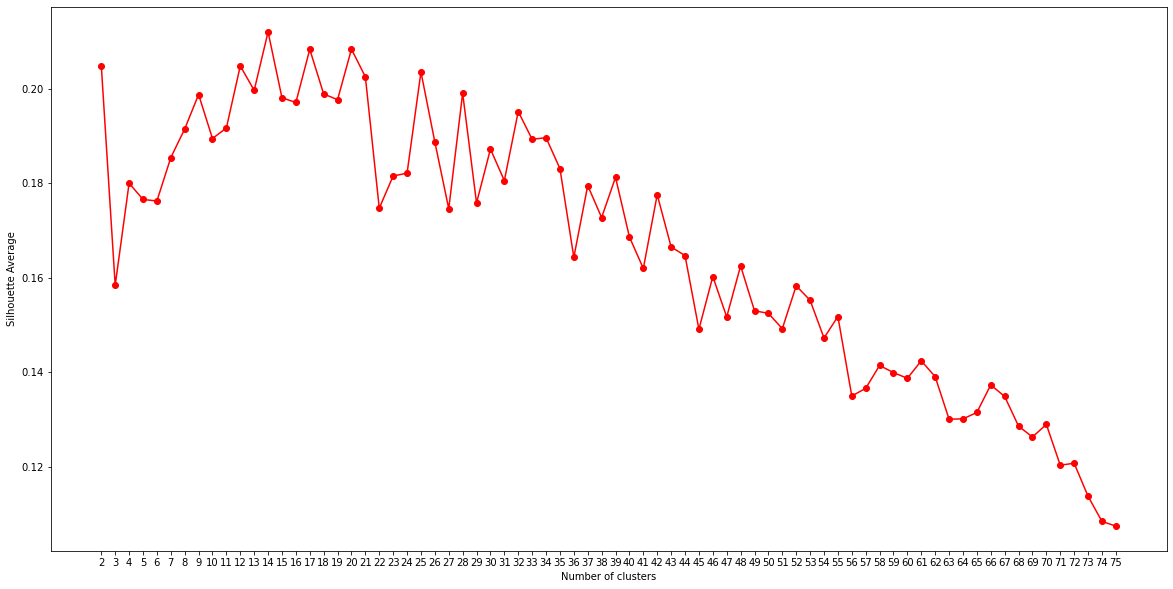

In [17]:
range_n_clusters = range(2,76)
silhouette_avg = []

for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels_list = clusterer.fit_predict(toronto_neighborhoods_grouped_clustering)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    score = silhouette_score(toronto_neighborhoods_grouped_clustering, cluster_labels_list)
    silhouette_avg.append(score)

plt.figure(figsize=(20,10))
plt.plot(range_n_clusters, silhouette_avg, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Average")
plt.xticks(range_n_clusters)
plt.show()

As seen from the above line plot, the highest silhouette score is for the number of clusters having 10 . So, let us consider the number of clusters to be 10.

In [18]:
# set number of clusters
kclusters = 10

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_neighborhoods_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[:10]

array([7, 0, 0, 8, 9, 2, 1, 5, 2, 3], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 20 venues for each neighborhood.

In [19]:
# add clustering labels
toronto_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_neighborhoods_merged = toronto_neighborhoods

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_neighborhoods_merged = toronto_neighborhoods_merged.join(toronto_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_neighborhoods_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,6,Zoo Exhibit,Coffee Shop,Pharmacy,Gas Station,Pizza Place,Sandwich Place,Fast Food Restaurant,Burger Joint,Fried Chicken Joint,Bank,Restaurant,Liquor Store,Indian Restaurant,Chinese Restaurant,Caribbean Restaurant,Grocery Store,Zoo,Athletics & Sports,Breakfast Spot,Park
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,6,Zoo Exhibit,Park,Coffee Shop,Pharmacy,Breakfast Spot,Gas Station,Pub,Restaurant,Liquor Store,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Pizza Place,Smoothie Shop,Chinese Restaurant,Sandwich Place,Zoo,Bank,Discount Store,Wings Joint
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,4,Coffee Shop,Bank,Sandwich Place,Pharmacy,Park,Indian Restaurant,Restaurant,Pizza Place,Ice Cream Shop,Beer Store,Fast Food Restaurant,Gym,Fried Chicken Joint,Burger Joint,Pub,Gas Station,Grocery Store,Breakfast Spot,Athletics & Sports,Chinese Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,4,Coffee Shop,Park,Pharmacy,Sandwich Place,Caribbean Restaurant,Pizza Place,Fast Food Restaurant,Breakfast Spot,Restaurant,Hotel,Bank,Burger Joint,Indian Restaurant,Pub,Fried Chicken Joint,Ice Cream Shop,Gas Station,Grocery Store,Japanese Restaurant,Beer Store
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,4,Coffee Shop,Indian Restaurant,Fast Food Restaurant,Pizza Place,Sandwich Place,Caribbean Restaurant,Fried Chicken Joint,Bank,Restaurant,Park,Pub,Burger Joint,Supermarket,Breakfast Spot,Bookstore,Ice Cream Shop,Cantonese Restaurant,Pharmacy,Asian Restaurant,Liquor Store


Finally, let's visualize the resulting clusters

In [20]:
# create map
map_clusters = folium.Map(location=[toronto_neighborhoods.Latitude.mean(), toronto_neighborhoods.Longitude.mean()], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.tab10(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_neighborhoods_merged['Latitude'], toronto_neighborhoods_merged['Longitude'], toronto_neighborhoods_merged['Neighborhood'], toronto_neighborhoods_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    cluster = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 6. Examine Clusters<a name="item6"></a> 

Now, Let's examine each cluster and determine the discriminating venue categories that distinguish each cluster. 

In [21]:
def clusters_venues_data(df):
    
    # most common venues column labels
    column_labels = list(df.columns[list(range(6, df.shape[1]))])
    
    # create a list containing each cluster dataframe
    clusters = [df.loc[df['Cluster Labels'] == knum, df.columns[[1] + [2] + list(range(5, df.shape[1]))]] for knum in range(0,kclusters)]
    
    # reset the index for each cluster dataframe
    clusters = [c.reset_index(drop=True) for c in clusters]
    
    # create list containing list of venues data for each cluster
    clusters_venues_list = []
    
    for c in clusters:
        clusters_venues = [value for col in column_labels for value in c[col]]
        clusters_venues_list.append(clusters_venues)
        
    # create list containing dataframe with venue & it's frequency in the data for each cluster
    venues_frequency_dict = []
    venues_frequency_dataframe = []
    
    for l in clusters_venues_list:
        venues_frequency = {k:l.count(k) for k in set(l)}
        venues_frequency_dict.append(venues_frequency)
        venues_frequency_dataframe.append(pd.DataFrame(venues_frequency.items(), columns=['Venue', 'Frequency']))
    
    return clusters, venues_frequency_dict, venues_frequency_dataframe
    

In [22]:
clusters, venues_frequency_dict, venues_frequency_dataframe  = clusters_venues_data(toronto_neighborhoods_merged)

Let's visualize list of common venues in each clusters through wordcloud plots. 

In [23]:
def clusters_plot(dic, daf):
    
    wordcloud_plot = []
    common_plot = []
    
    for d in dic:
        wordcloud = WordCloud(background_color='white', min_font_size=6,
                              max_font_size=20, max_words=200, random_state=0)
        wordcloud.generate_from_frequencies(d)
        fig = plt.figure(figsize=(10,8))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis('off')
        wordcloud_plot.append(fig)
        plt.close(fig)
        
    for df in daf:
        fig=plt.figure(figsize=(18,9))
        ax1=fig.add_subplot(2,2,1)
        ax2=fig.add_subplot(2,2,2)
        colors_array = cm.tab10(np.linspace(0, 1, 10))
        df.nlargest(round(len(df)/2), ['Frequency']).plot(ax=ax1, x="Venue", y="Frequency", kind="bar", color=colors_array, legend=None)
        df.nsmallest(round(len(df)/2), ['Frequency']).plot(ax=ax2, x="Venue", y="Frequency",kind="bar", color=colors_array, legend=None)
        ax1.set_ylabel("Frequency")
        ax2.set_ylabel("Frequency")
        ax1.set_title("Most Common Venues")
        ax2.set_title("Least Common Venues")
        common_plot.append(fig)
        plt.close(fig)
     
    return wordcloud_plot, common_plot

In [24]:
wordcloud_plot, common_plot = clusters_plot(venues_frequency_dict, venues_frequency_dataframe)

### Cluster 1

Let's have a look at the list of neighbourhoods and corresponding boroughs present in this cluster

In [25]:
clusters[0].iloc[:, 0:2]

,Borough,Neighborhood
0,North York,"York Mills, Silver Hills"
1,North York,York Mills West
2,North York,Don Mills North
3,North York,"Bathurst Manor, Wilson Heights, Downsview North"
4,North York,Downsview East
5,North York,Downsview West
6,North York,Downsview Central
7,North York,Victoria Village
8,North York,"North Park, Maple Leaf Park, Upwood Park"
9,Mississauga,Enclave of L4W


Let's visualize all the venues present in this cluster through a Wordcloud plot

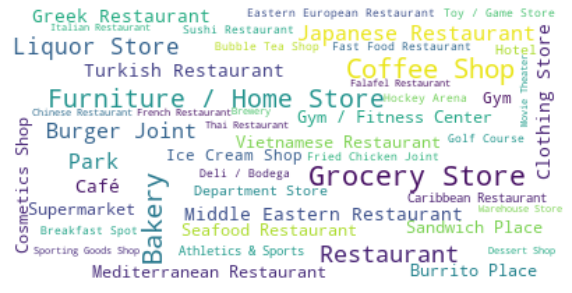

In [26]:
wordcloud_plot[0]

Let's visualize the list of most common venues, which are the venues that appear more frequently in the neighbourhood of this cluster. Alongside the least common venues located are also plotted.

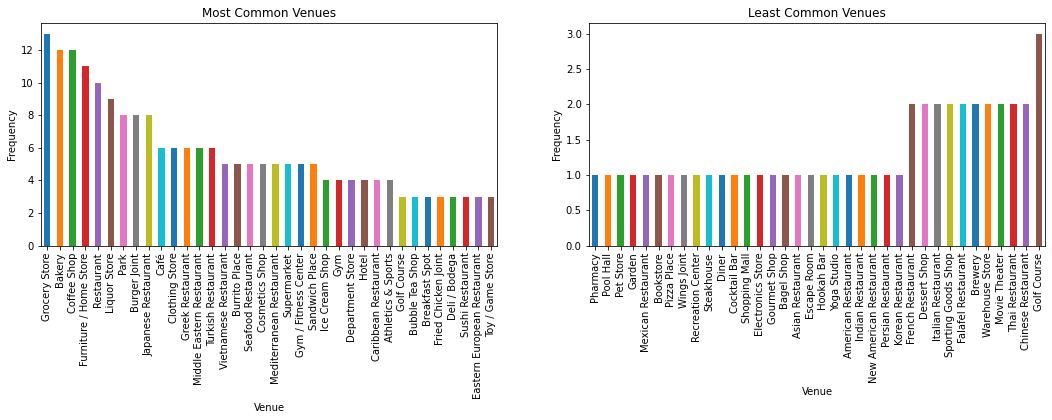

In [27]:
common_plot[0]

### Cluster 2

Let's have a look at the list of neighbourhoods and corresponding boroughs present in this cluster

In [28]:
clusters[1].iloc[:, 0:2]

,Borough,Neighborhood
0,Scarborough,"Golden Mile, Clairlea, Oakridge"
1,Scarborough,"Birch Cliff, Cliffside West"
2,East York,"Parkview Hill, Woodbine Gardens"
3,East York,Woodbine Heights
4,East Toronto,The Beaches
5,East York/East Toronto,The Danforth East
6,East Toronto,"The Danforth West, Riverdale"
7,East Toronto,"India Bazaar, The Beaches West"
8,East Toronto,Studio District
9,East Toronto Business,Enclave of M4L


Let's visualize all the venues present in this cluster through a Wordcloud plot. 

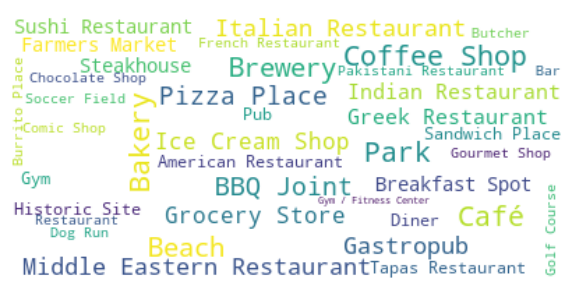

In [29]:
wordcloud_plot[1]

Let's visualize the list of most common venues, which are the venues that appear more frequently in the neighbourhood of this cluster. Alongside the least common venues located are also plotted.

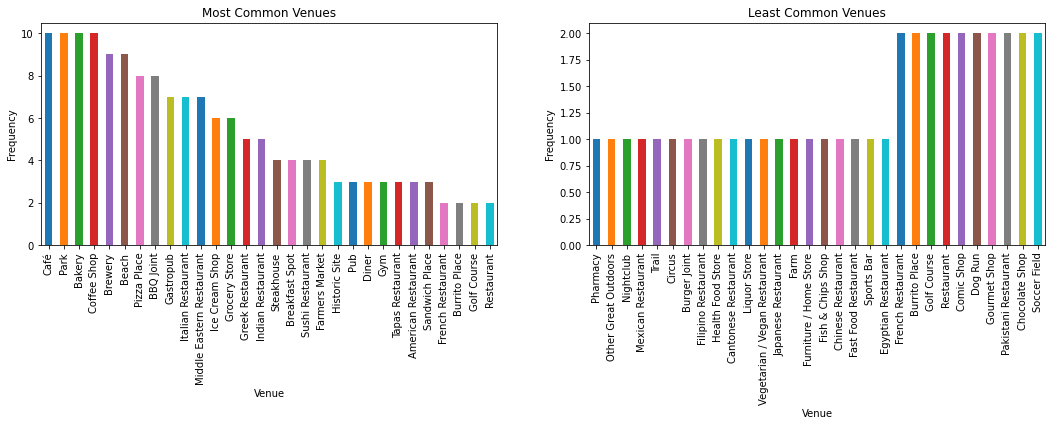

In [30]:
common_plot[1]

### Cluster 3

Let's have a look at the list of neighbourhoods and corresponding boroughs present in this cluster

In [31]:
clusters[2].iloc[:, 0:2]

,Borough,Neighborhood
0,Downtown Toronto,Rosedale
1,Downtown Toronto,"St. James Town, Cabbagetown"
2,Downtown Toronto,Church and Wellesley
3,Downtown Toronto,"Regent Park, Harbourfront"
4,Downtown Toronto,"Garden District, Ryerson"
5,Downtown Toronto,St. James Town
6,Downtown Toronto,Berczy Park
7,Downtown Toronto,Central Bay Street
8,Downtown Toronto,"Richmond, Adelaide, King"
9,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands"


Let's visualize all the venues present in this cluster through a Wordcloud plot

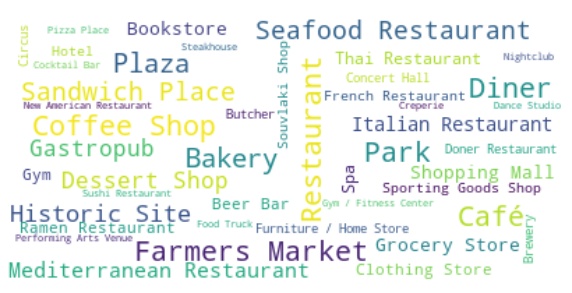

In [32]:
wordcloud_plot[2]

Let's visualize the list of most common venues, which are the venues that appear more frequently in the neighbourhood of this cluster. Alongside the least common venues located are also plotted.

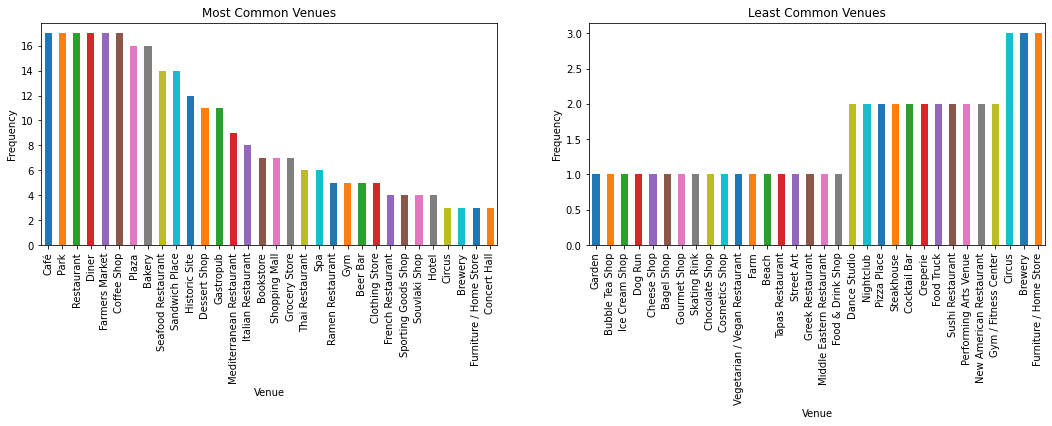

In [33]:
common_plot[2]

### Cluster 4

Let's have a look at the list of neighbourhoods and corresponding boroughs present in this cluster

In [34]:
clusters[3].iloc[:, 0:2]

,Borough,Neighborhood
0,York,Caledonia-Fairbanks
1,West Toronto,"Dufferin, Dovercourt Village"
2,York,"Del Ray, Mount Dennis, Keelsdale and Silverthorn"
3,York,"Runnymede, The Junction North"
4,West Toronto,"High Park, The Junction South"
5,West Toronto,"Parkdale, Roncesvalles"
6,West Toronto,"Runnymede, Swansea"
7,Etobicoke,"New Toronto, Mimico South, Humber Bay Shores"
8,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
9,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Humber Bay, Mimico NE, The Queensway East, Royal York South East, Kingsway Park South East"


Let's visualize all the venues present in this cluster through a Wordcloud plot

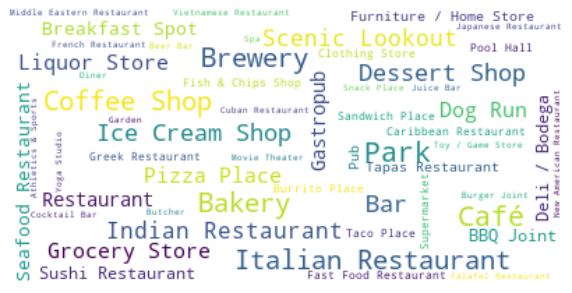

In [35]:
wordcloud_plot[3]

Let's visualize the list of most common venues, which are the venues that appear more frequently in the neighbourhood of this cluster. Alongside the least common venues located are also plotted.

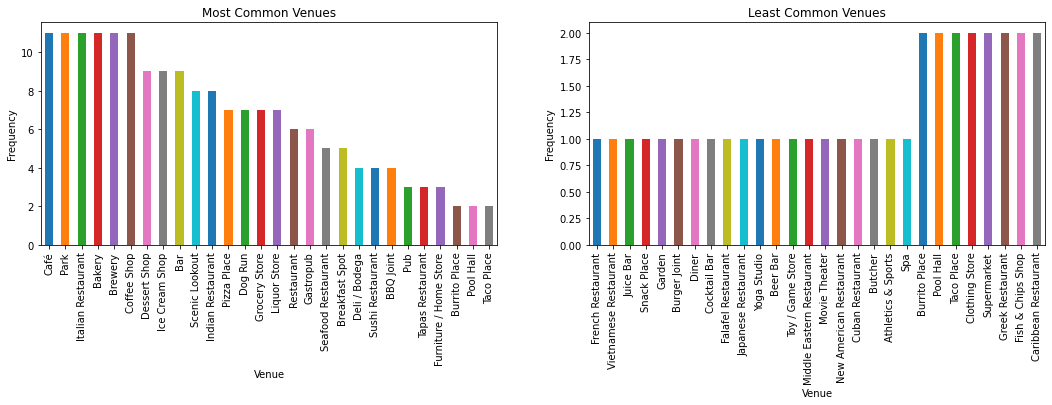

In [36]:
common_plot[3]

### Cluster 5

Let's have a look at the list of neighbourhoods and corresponding boroughs present in this cluster

In [37]:
clusters[4].iloc[:, 0:2]

,Borough,Neighborhood
0,Scarborough,"Guildwood, Morningside, West Hill"
1,Scarborough,Woburn
2,Scarborough,Cedarbrae
3,Scarborough,Scarborough Village
4,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West"
5,North York,Downsview Northwest
6,Etobicoke,Islington Avenue
7,North York,Humber Summit
8,North York,"Humberlea, Emery"
9,York,Weston


Let's visualize all the venues present in this cluster through a Wordcloud plot

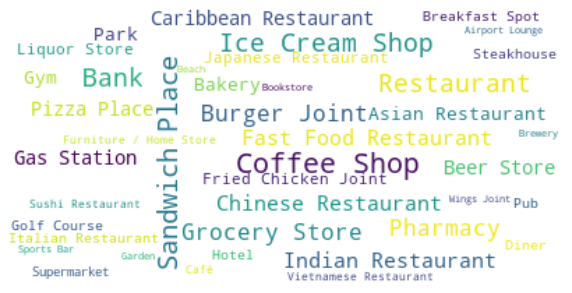

In [38]:
wordcloud_plot[4]

Let's visualize the list of most common venues, which are the venues that appear more frequently in the neighbourhood of this cluster. Alongside the least common venues located are also plotted.

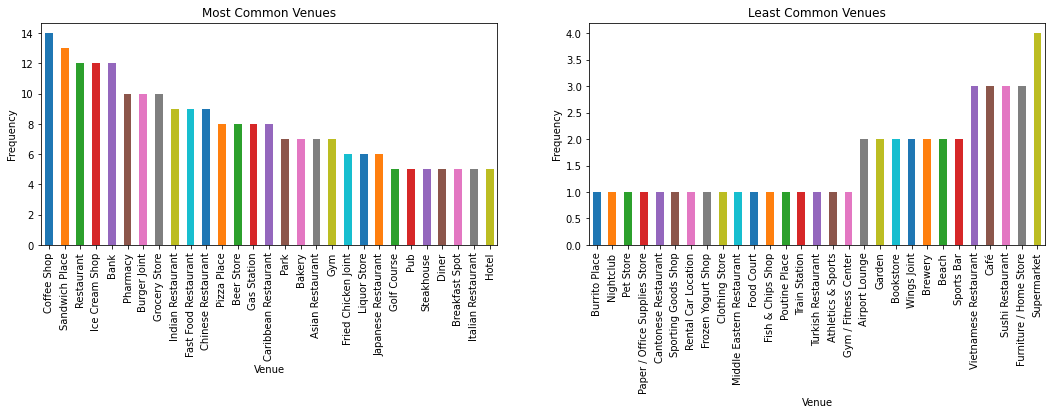

In [39]:
common_plot[4]

### Cluster 6

Let's have a look at the list of neighbourhoods and corresponding boroughs present in this cluster

In [40]:
clusters[5].iloc[:, 0:2]

,Borough,Neighborhood
0,East York,Leaside
1,East York,Thorncliffe Park
2,Central Toronto,Davisville
3,Central Toronto,"Moore Park, Summerhill East"
4,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park"
5,Central Toronto,Forest Hill North & West
6,Central Toronto,"The Annex, North Midtown, Yorkville"
7,Downtown Toronto,"University of Toronto, Harbord"
8,Downtown Toronto,Christie
9,West Toronto,"Little Portugal, Trinity"


Let's visualize all the venues present in this cluster through a Wordcloud plot

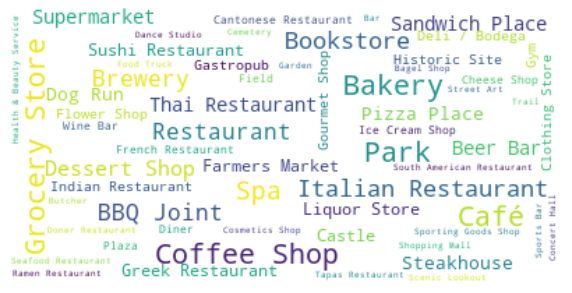

In [41]:
wordcloud_plot[5]

Let's visualize the list of most common venues, which are the venues that appear more frequently in the neighbourhood of this cluster. Alongside the least common venues located are also plotted.

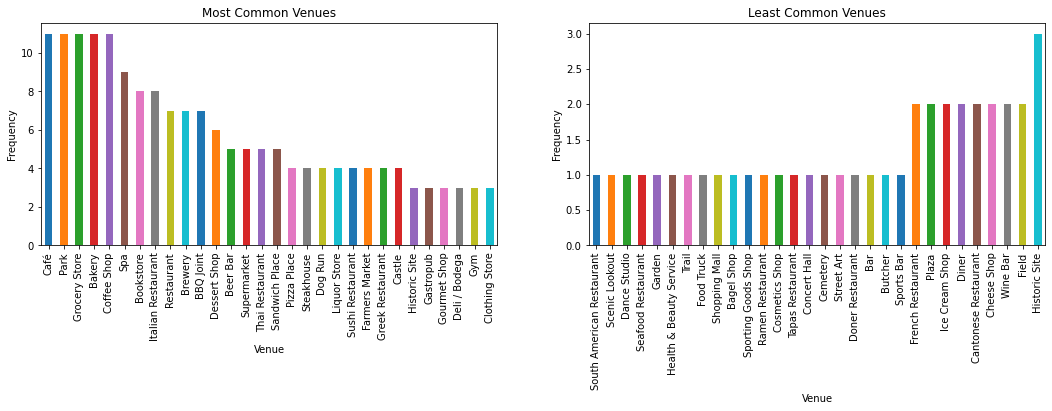

In [42]:
common_plot[5]

### Cluster 7

Let's have a look at the list of neighbourhoods and corresponding boroughs present in this cluster

In [43]:
clusters[6].iloc[:, 0:2]

,Borough,Neighborhood
0,Scarborough,"Malvern, Rouge"
1,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,Scarborough,Upper Rouge


Let's visualize all the venues present in this cluster through a Wordcloud plot

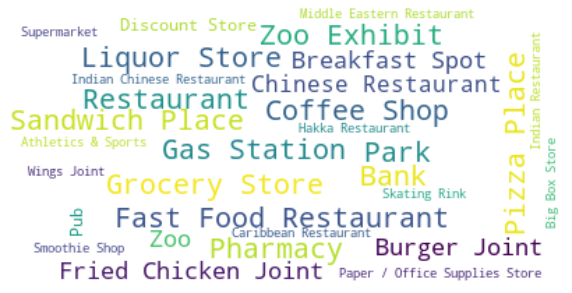

In [44]:
wordcloud_plot[6]

Let's visualize the list of most common venues, which are the venues that appear more frequently in the neighbourhood of this cluster. Alongside the least common venues located are also plotted.

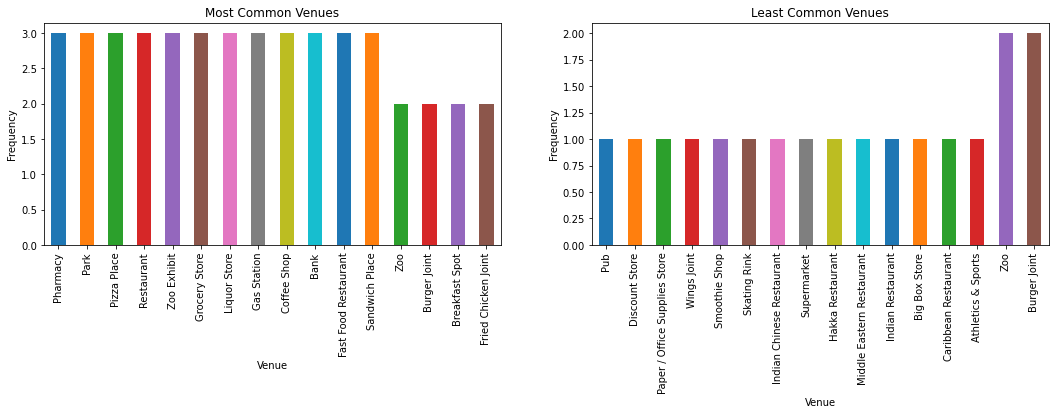

In [45]:
common_plot[6]

### Cluster 8

Let's have a look at the list of neighbourhoods and corresponding boroughs present in this cluster

In [46]:
clusters[7].iloc[:, 0:2]

,Borough,Neighborhood
0,Scarborough,"Dorset Park, Wexford Heights, Scarborough Town Centre"
1,Scarborough,"Wexford, Maryvale"
2,Scarborough,Agincourt
3,Scarborough,"Clarks Corners, Tam O'Shanter, Sullivan"
4,Scarborough,"Milliken, Agincourt North, Steeles East, L'Amoreaux East"
5,Scarborough,"Steeles West, L'Amoreaux West"
6,North York,Hillcrest Village
7,North York,"Fairview, Henry Farm, Oriole"
8,North York,Parkwoods


Let's visualize all the venues present in this cluster through a Wordcloud plot

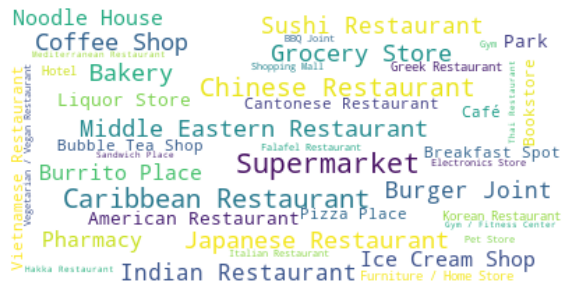

In [47]:
wordcloud_plot[7]

Let's visualize the list of most common venues, which are the venues that appear more frequently in the neighbourhood of this cluster. Alongside the least common venues located are also plotted.

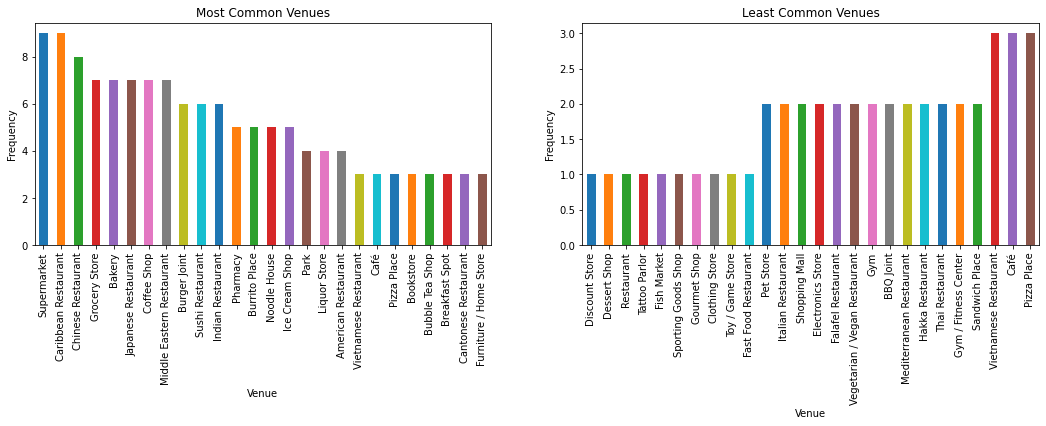

In [48]:
common_plot[7]

### Cluster 9

Let's have a look at the list of neighbourhoods and corresponding boroughs present in this cluster

In [49]:
clusters[8].iloc[:, 0:2]

,Borough,Neighborhood
0,Scarborough,"Kennedy Park, Ionview, East Birchmount Park"
1,North York,Bayview Village
2,North York,"Willowdale, Newtonbrook"
3,North York,Willowdale South
4,North York,Willowdale West
5,North York,"Northwood Park, York University"


Let's visualize all the venues present in this cluster through a Wordcloud plot

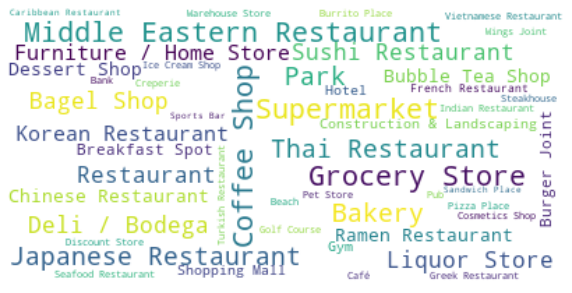

In [50]:
wordcloud_plot[8]

Let's visualize the list of most common venues, which are the venues that appear more frequently in the neighbourhood of this cluster. Alongside the least common venues located are also plotted.

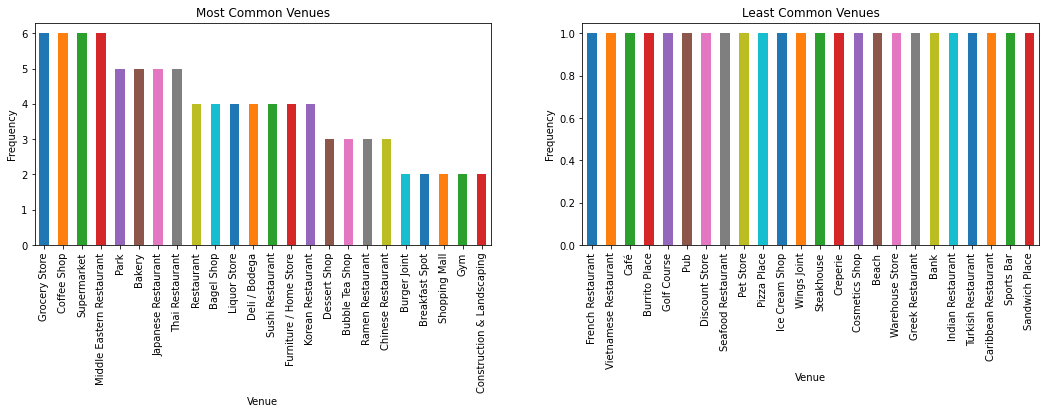

In [51]:
common_plot[8]

### Cluster 10

Let's have a look at the list of neighbourhoods and corresponding boroughs present in this cluster

In [52]:
clusters[9].iloc[:, 0:2]

,Borough,Neighborhood
0,North York,Don Mills South
1,Central Toronto,Lawrence Park
2,Central Toronto,Davisville North
3,Central Toronto,North Toronto West
4,North York,"Bedford Park, Lawrence Manor East"
5,Central Toronto,Roselawn
6,North York,"Lawrence Manor, Lawrence Heights"
7,North York,Glencairn
8,York,Humewood-Cedarvale


Let's visualize all the venues present in this cluster through a Wordcloud plot

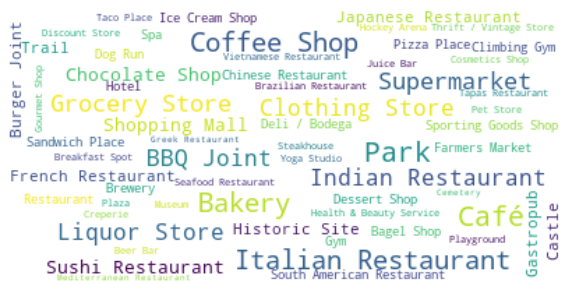

In [53]:
wordcloud_plot[9]

Let's visualize the list of most common venues, which are the venues that appear more frequently in the neighbourhood of this cluster. Alongside the least common venues located are also plotted.

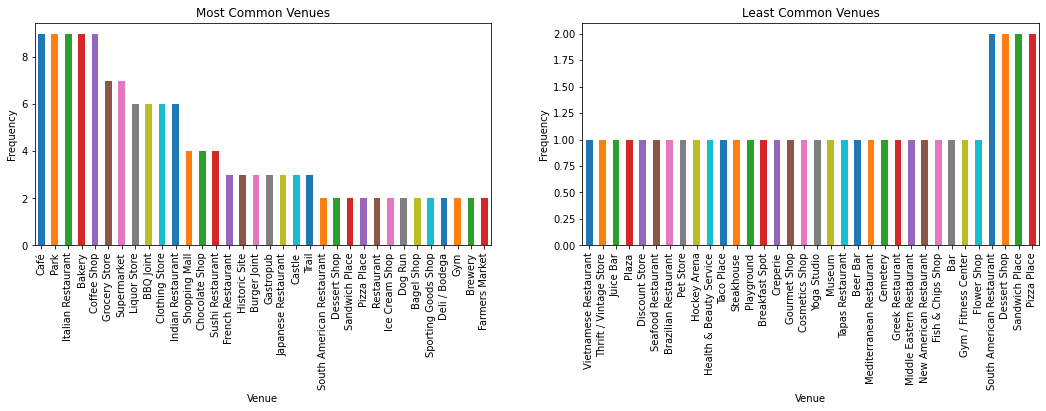

In [54]:
common_plot[9]

## 7. Discussion & Conclusion<a name="item7"></a>